In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import re
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pickle
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm_notebook
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from sklearn.linear_model import LogisticRegression
from scipy import sparse
from prettytable import PrettyTable
import xgboost as xgb

In [4]:
X_train_tfidf = sparse.load_npz('X_train_tfidf_sc.npz')
X_test_tfidf = sparse.load_npz('X_test_tfidf_sc.npz')

y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

In [5]:
params_tfidf = {'n_estimators': [5, 10, 50, 75, 100, 200], 'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]}

xgb_clf = xgb.XGBClassifier()

clf_tfidf = GridSearchCV(xgb_clf, params_tfidf, cv=3, scoring='roc_auc', return_train_score=True)
clf_tfidf.fit(X_train_tfidf, y_train)

print(clf_tfidf.best_params_)
print(clf_tfidf.best_score_)

{'learning_rate': 0.1, 'n_estimators': 200}
0.6919904804491206


In [6]:
test_score_tfidf = clf_tfidf.cv_results_['mean_test_score']
train_score_tfidf = clf_tfidf.cv_results_['mean_train_score']

# https://www.kite.com/python/answers/how-to-split-a-list-into-n-parts-in-python
train_score_tfidf_hm = pd.DataFrame(np.array_split(train_score_tfidf, 6)).transpose()
test_score_tfidf_hm = pd.DataFrame(np.array_split(test_score_tfidf, 6)).transpose()

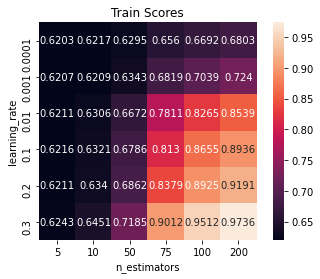

In [7]:
plt.figure()
sns.heatmap(train_score_tfidf_hm, annot=True, square=True, xticklabels=params_tfidf['n_estimators'], yticklabels=params_tfidf['learning_rate'], fmt='0.4')
plt.xlabel('n_estimators')
plt.ylabel('learning_rate')
plt.title('Train Scores')
plt.show()

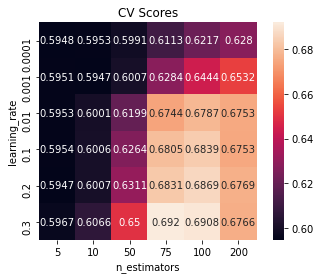

In [8]:
plt.figure()
sns.heatmap(test_score_tfidf_hm, annot=True, square=True, xticklabels=params_tfidf['n_estimators'], yticklabels=params_tfidf['learning_rate'], fmt='0.4')
plt.xlabel('n_estimators')
plt.ylabel('learning_rate')
plt.title('CV Scores')
plt.show()

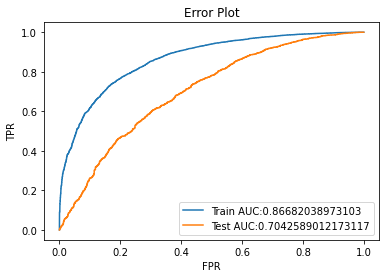

In [9]:
# training best model on best hyperparameters for set-1

best_model_tfidf = xgb.XGBClassifier(n_estimators=clf_tfidf.best_params_['n_estimators'], learning_rate=clf_tfidf.best_params_['learning_rate'])
best_model_tfidf.fit(X_train_tfidf, y_train)

y_train_predict_tfidf = best_model_tfidf.predict_proba(X_train_tfidf)[:,1]
y_test_predict_tfidf = best_model_tfidf.predict_proba(X_test_tfidf)[:,1]

fpr1_tfidf, tpr1_tfidf, thresholds1_tfidf = roc_curve(y_train, y_train_predict_tfidf)
fpr2_tfidf, tpr2_tfidf, thresholds2_tfidf = roc_curve(y_test, y_test_predict_tfidf)

plt.figure()
plt.plot(fpr1_tfidf, tpr1_tfidf, label='Train AUC:'+str(auc(fpr1_tfidf,tpr1_tfidf)))
plt.plot(fpr2_tfidf, tpr2_tfidf, label='Test AUC:'+str(auc(fpr2_tfidf,tpr2_tfidf)))
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Error Plot')
plt.show()

In [10]:
def find_best_threshold(threshold, fpr, tpr):
    return threshold[np.argmax(tpr*(1-fpr))]

def predict_with_best_threshold(proba, threshold):
    predictions = []
    for i in proba:
        if i>= threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

Best threshold for TFIDF model:  0.8274576


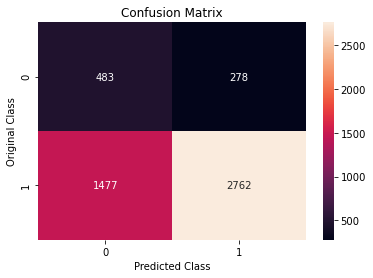

In [11]:
best_t_tfidf = find_best_threshold(thresholds1_tfidf, fpr1_tfidf, tpr1_tfidf)
print('Best threshold for TFIDF model: ', best_t_tfidf)

cm_tfidf = confusion_matrix(y_test, predict_with_best_threshold(y_test_predict_tfidf, best_t_tfidf))

plt.figure()
sns.heatmap(cm_tfidf, annot=True, fmt='1')
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.title('Confusion Matrix')
plt.show()